# Metric Analysis for Rewiring Techniques

## Import utils

In [1]:
import os
import pygsheets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re


## Google API Setup

In [4]:
# Set the env var inside the notebook
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/alexandre/Documents/API/l65-gdl-dfbb4fdd8c94.json" # CHANGE THIS PATH

client = pygsheets.authorize(service_account_file=os.environ["GOOGLE_APPLICATION_CREDENTIALS"])
print(client.spreadsheet_titles)


<bound method Client.spreadsheet_titles of <pygsheets.client.Client object at 0x790f35ba8b80>>


Open the google sheet

In [5]:
# Open the Google Sheet with ID. The ID is the part of the url between the "/d/" and the "/edit"
SHEET_ID = "1iGEXfqWMPuTauYstnAYd16mc3medq7tubY_PT3_GeNY"
spreadsheet = client.open_by_key(SHEET_ID)

Select the worksheet

In [4]:
worksheet = spreadsheet.worksheet_by_title("Unrewired")

Read data

## Metrics evaluation

/media/alexandre/morespace/data/amgb20/CAM_venv/lib/python3.10/site-packages/pygsheets/worksheet.py:1554: UserWarning: At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.
  warnings.warn('At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.')
/tmp/ipykernel_69557/97702513.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Dataset"] = df["Dataset"].fillna(method="ffill")
/tmp/ipykernel_69557/97702513.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


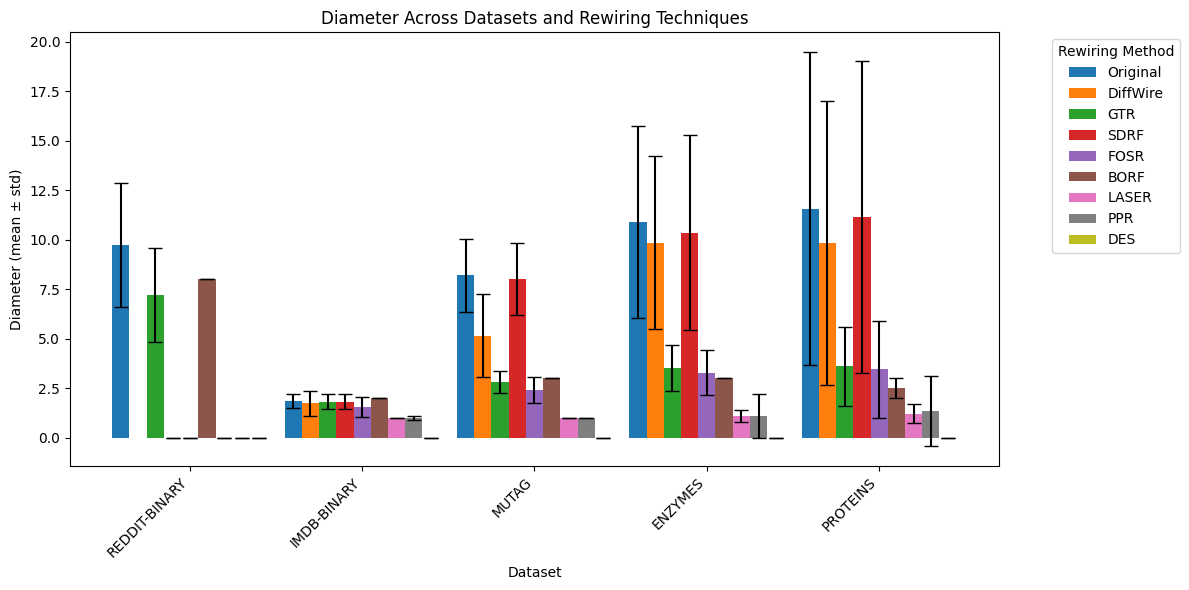

In [31]:
worksheet_data_specific = spreadsheet.worksheet_by_title("Dataset_Specific")

df = worksheet_data_specific.get_as_df()


# Rename columns for clarity
df.columns = ["Dataset", "Metric"] + df.iloc[0, 2:].tolist()
df = df[1:].reset_index(drop=True)

# Forward fill dataset names where missing
df["Dataset"] = df["Dataset"].fillna(method="ffill")

# Remove extra spaces and newlines
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

for col in df.columns[2:]:
    # Split on '±' to get two parts: mean and std.
    # expand=True returns a DataFrame with two columns
    mean_std = df[col].str.split('±', expand=True)
    
    # Rename those columns appropriately
    df[col + "_mean"] = mean_std[0]  # left side of ±
    df[col + "_std"] = mean_std[1]   # right side of ±

    # Convert them to numeric (float). You can handle errors with 'coerce' if needed.
    df[col + "_mean"] = pd.to_numeric(df[col + "_mean"], errors='coerce')
    df[col + "_std"]  = pd.to_numeric(df[col + "_std"], errors='coerce')

diameter_df = df[df["Metric"] == "Diameter"].copy()

# Extract mean and std columns
mean_cols = [c for c in diameter_df.columns if c.endswith("_mean")]
std_cols = [c.replace("_mean", "_std") for c in mean_cols]
rewiring_methods = [c.replace("_mean", "") for c in mean_cols]

# # Check for missing or non-numeric values in the mean and std columns
# invalid_means = diameter_df[mean_cols].isna().sum()
# invalid_stds = diameter_df[std_cols].isna().sum()


# Convert columns to numeric, forcing errors to NaN for clean processing
for col in mean_cols + std_cols:
    diameter_df[col] = pd.to_numeric(diameter_df[col], errors='coerce')

# # Drop rows where all rewiring results are NaN
# diameter_df = diameter_df.dropna(subset=mean_cols, how='all')

# # Drop rows where any mean values are NaN
# diameter_df_cleaned = diameter_df.dropna(subset=mean_cols)

# Drop rows that contains COLLAB
diameter_df = diameter_df[~diameter_df["Dataset"].str.contains("COLLAB")]

# Ensure all values are numeric
for col in mean_cols + std_cols:
    diameter_df[col] = pd.to_numeric(diameter_df[col], errors='coerce')

fig, ax = plt.subplots(figsize=(12, 6))

datasets = diameter_df["Dataset"].unique()
x = np.arange(len(datasets))  # Positions for dataset groups
bar_width = 0.1  # Width of each bar

# Plot each rewiring method
for i, rew in enumerate(rewiring_methods):
    means = [diameter_df[diameter_df["Dataset"] == ds][rew + "_mean"].values[0] for ds in datasets]
    stds = [diameter_df[diameter_df["Dataset"] == ds][rew + "_std"].values[0] for ds in datasets]

    # Compute bar positions
    x_pos = x + (i - len(rewiring_methods)/2) * bar_width + bar_width/2
    
    ax.bar(x_pos, means, yerr=stds, width=bar_width, label=rew, capsize=5)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45, ha="right")
ax.set_title("Diameter Across Datasets and Rewiring Techniques")
ax.set_xlabel("Dataset")
ax.set_ylabel("Diameter (mean ± std)")
ax.legend(title="Rewiring Method", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()